# Static Hand Gesture UI Control

**Course Project:** Computer Vision Applications  
**Goal:** Control PC volume and media playback using real-time static hand gestures.

## Project Overview
This project implements a touchless interface using a standard webcam. It detects hand landmarks using **MediaPipe Hands**, extracts a 63-dimensional feature vector (21 points × x,y,z), and classifies the pose using a **Support Vector Machine (SVM)**. The recognized gestures are then mapped to system actions (Volume Up/Down, Mute, Play/Pause) via Python automation libraries.

### Workflow
1.  **Data Collection:** Capture labeled landmark samples for 5 gestures (Stop, Fist, Victory, Like, OK).
2.  **Model Training:** Train a lightweight SVM classifier on the collected dataset.
3.  **Real-Time Demo:** Run a live inference loop to control the PC.

## Setup Instructions
1.  **Create Environment:**
    ```powershell
    python -m venv .venv
    .\.venv\Scripts\Activate.ps1
    ```
2.  **Install Dependencies:**
    ```powershell
    pip install -r requirements.txt
    ```
3.  **Run Notebook:** Execute the cells below in order.

In [2]:
import sys
print(sys.executable)
print(sys.version)

c:\Users\Madi\Documents\season_25-26\academic_25-26\EE4211\compvision_proj\gesture-recog\.venv\Scripts\python.exe
3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import csv
from collections import Counter

mp_hands = mp.solutions.hands
# Updated to support 2 hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.7)
mp_drawing = mp.solutions.drawing_utils

gesture_names = ["Stop", "Fist", "Victory", "Like", "OK"]
data = []
sample_counts = Counter()  # Track samples per gesture

cap = cv2.VideoCapture(0)
current_gesture = -1

# Make window visible and position it
window_name = 'Data Collection – Press 0–4 to record, q to quit'
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
cv2.resizeWindow(window_name, 800, 600)
cv2.moveWindow(window_name, 100, 100)  # Position at top-left

print("=" * 60)
print("DATA COLLECTION STARTED (Dual Hand Support)")
print("=" * 60)
print("Instructions:")
print("  - Press 0-4 to start recording that gesture")
print("  - Press SPACE to PAUSE recording (use this to switch gestures!)")
print("  - Hold the pose for a few seconds (aim for ~200+ samples per gesture)")
print("  - You can use ONE or BOTH hands. Each detected hand counts as a sample.")
print("  - Press 'q' in the video window to quit and save")
print("=" * 60)
print("\nWaiting for gesture selection...")

frame_count = 0
last_print_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("ERROR: Could not read from camera. Check camera permissions.")
        break
    
    frame = cv2.flip(frame, 1)  # mirror
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb_frame)

    # Count samples per gesture for display
    if data:
        sample_counts = Counter([row[-1] for row in data])
    
    # Draw on frame
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # Extract & save when recording
            if 0 <= current_gesture < len(gesture_names):
                landmarks = []
                for lm in hand_landmarks.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])
                landmarks.append(current_gesture)  # label at the end
                data.append(landmarks)
        
        # Show current gesture name and sample count
        if 0 <= current_gesture < len(gesture_names):
            count = sample_counts.get(current_gesture, 0)
            text = f"Recording: {gesture_names[current_gesture]} ({count} samples)"
            cv2.putText(frame, text, (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 3)
        else:
            cv2.putText(frame, "PAUSED: Press 0-4 to record", (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
    else:
        # No hand detected
        if current_gesture >= 0:
            cv2.putText(frame, f"Recording: {gesture_names[current_gesture]} (no hand detected)", 
                       (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    
    # Show sample counts for all gestures
    y_offset = 100
    cv2.putText(frame, "Sample counts:", (10, y_offset),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    for i, name in enumerate(gesture_names):
        count = sample_counts.get(i, 0)
        color = (0, 255, 0) if count >= 200 else (0, 165, 255) if count >= 100 else (0, 0, 255)
        cv2.putText(frame, f"  {i}: {name} = {count}", (10, y_offset + 30 + i * 25),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    # Show total
    total = len(data)
    cv2.putText(frame, f"TOTAL: {total} samples", (10, y_offset + 180),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)

    cv2.imshow(window_name, frame)

    # Print progress every 50 samples
    if len(data) - last_print_count >= 50:
        print(f"\nProgress: {len(data)} total samples collected")
        for i, name in enumerate(gesture_names):
            count = sample_counts.get(i, 0)
            print(f"  {i}: {name} = {count} samples")
        last_print_count = len(data)

    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        print("\nQuitting...")
        break
    elif key == ord(' '):
        current_gesture = -1
        print("\n>>> PAUSED recording. Switch your hand pose, then press 0-4 to resume.")
    elif key in [ord('0'), ord('1'), ord('2'), ord('3'), ord('4')]:
        current_gesture = int(chr(key))
        print(f"\n>>> Now recording: {gesture_names[current_gesture]}")

cap.release()
cv2.destroyAllWindows()

# Save
if data:
    with open('gesture_data.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([f'x{i}' for i in range(63)] + ['label'])
        writer.writerows(data)
    
    print("\n" + "=" * 60)
    print(f"SUCCESS! Saved {len(data)} samples to gesture_data.csv")
    print("=" * 60)
    print("Sample breakdown:")
    final_counts = Counter([row[-1] for row in data])
    for i, name in enumerate(gesture_names):
        count = final_counts.get(i, 0)
        status = "✓" if count >= 200 else "⚠" if count >= 100 else "✗"
        print(f"  {status} {i}: {name} = {count} samples")
    print("=" * 60)
else:
    print("\nWARNING: No data collected! Make sure to press 0-4 to start recording.")

DATA COLLECTION STARTED
Instructions:
  - Press 0-4 to start recording that gesture
  - Press SPACE to PAUSE recording (use this to switch gestures!)
  - Hold the pose for a few seconds (aim for ~200+ samples per gesture)
  - Press 'q' in the video window to quit and save

Waiting for gesture selection...

>>> Now recording: Stop

>>> Now recording: Stop

Progress: 50 total samples collected
  0: Stop = 49 samples
  1: Fist = 0 samples
  2: Victory = 0 samples
  3: Like = 0 samples
  4: OK = 0 samples

Progress: 50 total samples collected
  0: Stop = 49 samples
  1: Fist = 0 samples
  2: Victory = 0 samples
  3: Like = 0 samples
  4: OK = 0 samples

Progress: 100 total samples collected
  0: Stop = 99 samples
  1: Fist = 0 samples
  2: Victory = 0 samples
  3: Like = 0 samples
  4: OK = 0 samples

Progress: 100 total samples collected
  0: Stop = 99 samples
  1: Fist = 0 samples
  2: Victory = 0 samples
  3: Like = 0 samples
  4: OK = 0 samples

Progress: 150 total samples collected
  

## Day 1 – Data Collection

Use the cell below to capture training data for the 5 static gestures described in `docs/idea.md`:

0. **Stop** – open palm (all fingers extended)
1. **Fist** – closed hand
2. **Victory** – index + middle fingers up
3. **Like** – thumbs up
4. **OK** – thumb and index touching (OK sign)

**How to record:**
- Make sure your virtualenv is active and dependencies are installed.
- Run the data collection cell.
- For each gesture class 0–4:
  - Press the corresponding number key (e.g., `0` for Stop) while holding the pose.
  - Hold the pose for a few seconds so multiple samples are recorded.
  - Vary distance from the camera, slight rotations, and lighting.
- Aim for **~200+ samples per class** (total ≈ 1,000 samples).
- When you are done, press `q` to stop and save `gesture_data.csv` in the project root.



## Day 2 – Training & Evaluation

In this section you will:
- Load `gesture_data.csv` collected on Day 1.
- Train a **StandardScaler + SVM (RBF, C=10)** classifier.
- Evaluate with accuracy and a full classification report.
- Plot a confusion matrix (for your report Fig 3).
- Save the trained model as `gesture_classifier.pkl`.

Make sure `gesture_data.csv` is present in the project root before running the next cell.


Test accuracy: 0.9919

Classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        68
           2       0.97      1.00      0.98        92
           3       1.00      0.97      0.98        94
           4       1.00      1.00      1.00        65

    accuracy                           0.99       372
   macro avg       0.99      0.99      0.99       372
weighted avg       0.99      0.99      0.99       372



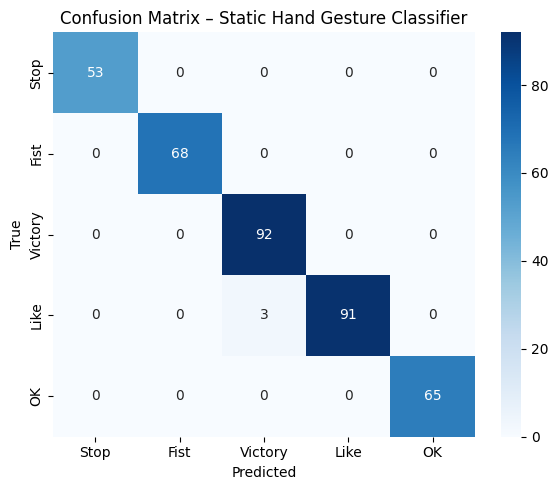

Saved model to gesture_classifier.pkl


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('gesture_data.csv')
X = df.iloc[:, :-1].values
y = df['label'].values

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# SVM pipeline
clf = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=10, gamma='scale', probability=True)
)
clf.fit(X_train, y_train)

# Evaluation
accuracy = clf.score(X_test, y_test)
print(f"Test accuracy: {accuracy:.4f}")

y_pred = clf.predict(X_test)
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Stop", "Fist", "Victory", "Like", "OK"],
            yticklabels=["Stop", "Fist", "Victory", "Like", "OK"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix – Static Hand Gesture Classifier')
plt.tight_layout()
plt.show()

# Save model
joblib.dump(clf, 'gesture_classifier.pkl')
print("Saved model to gesture_classifier.pkl")



## Day 3 – Real-time Demo + System Control

This section loads the trained model and runs **real-time gesture recognition** from your webcam, mapping each class to a system action using `pyautogui` and `pycaw`:

- **Stop (0)** → Play/Pause (space key)
- **Fist (1)** → Toggle mute
- **Victory (2)** → Next track/slide (Ctrl+Right)
- **Like (3)** → Volume up (+10%)
- **OK (4)** → Volume down (−10%)

Safeguards from `docs/idea.md` are implemented:
- Confidence threshold **p ≥ 0.90**.
- Debounce window of **~0.8 s** between identical triggers.

Make sure:
- You are running on native Windows (not WSL).
- `gesture_classifier.pkl` exists from Day 2.
- Your webcam and audio output are working.



In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import joblib
import pyautogui
from pycaw.pycaw import AudioUtilities, IAudioEndpointVolume
from comtypes import CLSCTX_ALL
from ctypes import cast, POINTER
import time

# Gesture names must match training order
gesture_names = ["Stop", "Fist", "Victory", "Like", "OK"]

# Load trained classifier
clf = joblib.load('gesture_classifier.pkl')

# Setup MediaPipe Hands
mp_hands = mp.solutions.hands
# Updated to support 2 hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.7)
mp_drawing = mp.solutions.drawing_utils

# Setup system volume control (pycaw)
try:
    devices = AudioUtilities.GetSpeakers()
    interface = devices.Activate(IAudioEndpointVolume._iid_, CLSCTX_ALL, None)
    volume = cast(interface, POINTER(IAudioEndpointVolume))
    print(f"Volume control initialized successfully.")
except Exception as e:
    print(f"Warning: Could not initialize volume control: {e}")
    print("Volume gestures (3=Like, 4=OK) will not work, but other gestures will.")
    volume = None

last_gesture = -1
last_trigger_time = 0.0
confidence_threshold = 0.75
cooldown_seconds = 0.8

print(f"Confidence threshold: {confidence_threshold}")
print(f"Debounce cooldown: {cooldown_seconds}s")
print("Watch the video window for status:")
print("  - GREEN [READY] = action will trigger")
print("  - ORANGE [WAIT] = waiting for debounce")
print("  - RED [LOW CONF] = confidence too low")

cap = cv2.VideoCapture(0)

# Create a resizable window
window_name = 'Static Gesture UI Control – Press q to quit'
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
cv2.resizeWindow(window_name, 1280, 720)

print("Starting real-time gesture control. Press 'q' to quit.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb_frame)

    if results.multi_hand_landmarks:
        # Iterate over all detected hands
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # Build feature vector
            landmarks = []
            for lm in hand_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z])
            landmarks = np.array([landmarks])

            # Predict class + probability
            probs = clf.predict_proba(landmarks)[0]
            prediction = int(np.argmax(probs))
            confidence = float(np.max(probs))

            now = time.time()
            
            # Check if action should trigger
            confidence_ok = confidence >= confidence_threshold
            # Global debounce: check if ANY action was triggered recently
            debounce_ok = (prediction != last_gesture or now - last_trigger_time >= cooldown_seconds)
            
            # Determine status color
            if confidence_ok and debounce_ok:
                color = (0, 255, 0)  # Green
                status = "READY"
            elif confidence_ok:
                color = (0, 165, 255)  # Orange
                status = "WAIT"
            else:
                color = (0, 0, 255)  # Red
                status = "LOW CONF"
            
            # Position text near the hand (wrist)
            wrist = hand_landmarks.landmark[0]
            h, w, _ = frame.shape
            txt_x, txt_y = int(wrist.x * w), int(wrist.y * h) - 20
            
            # Ensure text stays on screen
            txt_x = max(10, min(w - 200, txt_x))
            txt_y = max(30, min(h - 10, txt_y))

            label = f"{gesture_names[prediction]} ({confidence:.2f})"
            cv2.putText(frame, label, (txt_x, txt_y), cv2.FONT_HERSHEY_SIMPLEX,
                        0.7, color, 2, cv2.LINE_AA)
            
            # Trigger actions if conditions are met
            if confidence_ok and debounce_ok:
                # Trigger mapped actions
                if prediction == 0:      # Stop → Play/Pause
                    pyautogui.press('space')
                    print(f"✓ {gesture_names[prediction]} ({confidence:.2f}) → Play/Pause (Space)")
                elif prediction == 1:    # Fist → Toggle mute
                    if volume is not None:
                        muted = volume.GetMute()
                        volume.SetMute(not muted, None)
                        print(f"✓ {gesture_names[prediction]} ({confidence:.2f}) → Mute {'ON' if not muted else 'OFF'}")
                    else:
                        print(f"✓ {gesture_names[prediction]} ({confidence:.2f}) → Mute (volume control not available)")
                elif prediction == 2:    # Victory → Next
                    pyautogui.hotkey('ctrl', 'right')
                    print(f"✓ {gesture_names[prediction]} ({confidence:.2f}) → Next (Ctrl+Right)")
                elif prediction == 3:    # Like → Volume up
                    if volume is not None:
                        current = volume.GetMasterVolumeLevelScalar()
                        new_vol = min(1.0, current + 0.1)
                        volume.SetMasterVolumeLevelScalar(new_vol, None)
                        print(f"✓ {gesture_names[prediction]} ({confidence:.2f}) → Volume UP ({int(new_vol*100)}%)")
                    else:
                        print(f"✓ {gesture_names[prediction]} ({confidence:.2f}) → Volume UP (volume control not available)")
                elif prediction == 4:    # OK → Volume down
                    if volume is not None:
                        current = volume.GetMasterVolumeLevelScalar()
                        new_vol = max(0.0, current - 0.1)
                        volume.SetMasterVolumeLevelScalar(new_vol, None)
                        print(f"✓ {gesture_names[prediction]} ({confidence:.2f}) → Volume DOWN ({int(new_vol*100)}%)")
                    else:
                        print(f"✓ {gesture_names[prediction]} ({confidence:.2f}) → Volume DOWN (volume control not available)")

                last_gesture = prediction
                last_trigger_time = now

    cv2.imshow(window_name, frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Volume control initialized successfully.
Confidence threshold: 0.75
Debounce cooldown: 0.8s
Watch the video window for status:
  - GREEN [READY] = action will trigger
  - ORANGE [WAIT] = waiting for debounce
  - RED [LOW CONF] = confidence too low
Starting real-time gesture control. Press 'q' to quit.
Starting real-time gesture control. Press 'q' to quit.
✓ Stop (0.96) → Play/Pause (Space)
✓ Stop (0.96) → Play/Pause (Space)
✓ Stop (0.84) → Play/Pause (Space)
✓ Stop (0.84) → Play/Pause (Space)
✓ Stop (0.89) → Play/Pause (Space)
✓ Stop (0.89) → Play/Pause (Space)
✓ Victory (0.83) → Next (Ctrl+Right)
✓ Victory (0.83) → Next (Ctrl+Right)
✓ Victory (0.89) → Next (Ctrl+Right)
✓ Victory (0.89) → Next (Ctrl+Right)
✓ Stop (0.89) → Play/Pause (Space)
✓ Stop (0.89) → Play/Pause (Space)
✓ Stop (0.91) → Play/Pause (Space)
✓ Stop (0.91) → Play/Pause (Space)
✓ Stop (0.92) → Play/Pause (Space)
✓ Stop (0.92) → Play/Pause (Space)
✓ Stop (0.80) → Play/Pause (Space)
✓ Stop (0.80) → Play/Pause (Space)
✓ Fi